Machine learning methods can be broadly classified into: supervised learning, unsupervised learning, and reinforcement learning.

The previously introduced decision tree model and recurrent neural network are supervised learning models that use known prices to adjust predicted prices, making the model more accurate.

The difference with reinforcement learning is:

There is no supervised signal or label (known price) in the calculation formula. There is only a reward (feedback).
The feedback is delayed and cannot be reflected immediately.
The input during training is time-series related.
The action taken by the agent (decision maker) will affect the subsequent data.
What we are going to do now is:

Obtain an optimal strategy (jumping timing) for a specific problem (jumping as far as possible).
Maximize the reward (score) obtained under this strategy.
Here, the strategy is actually a series of actions (sequence data).


Using Reinforcement Learning to Simulate Trading

[Reference algorithm](https://github.com/SaAPro/agent-trading-deep-evolution-strategy)

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
spy_prices = pd.read_csv('/content/SPY_2018.csv')
spy_prices.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,267.839996,268.809998,267.399994,268.769989,258.858276,86655700
1,2018-01-03,268.959991,270.640015,268.959991,270.470001,260.495544,90070400
2,2018-01-04,271.200012,272.160004,270.540009,271.609985,261.593475,80636400


In [4]:
class DeepEvolutionStrategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def getWeights(self):
        return self.weights

    def train(self, epoch=100, print_every=1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    f'Epoch {i + 1}. Final Reward: {self.reward_function(self.weights)}'
                )
        print('=====================================')
        print(f'Training Time: {time.time() - lasttime} seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def getWeights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights


In [6]:

class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = DeepEvolutionStrategy(
            self.model.getWeights(),
            self.getReward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def getState(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def getReward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.getState(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.getState(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('Day %s > Buy 1 stock at price %s, Total assets %s' % (
                    str(t).rjust(3),
                    str("%.5f" % self.trend[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10)
                ))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('Day %s > Sell 1 stock at price %s, Total assets %s > Profit %s %%' % (
                    str(t).rjust(3),
                    str("%.5f" % close[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10),
                    str("%.2f" % invest).rjust(5)
                ))
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


In [7]:
close = spy_prices.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model,
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 100)

Epoch 100. Final Reward: 24.607002119999873
Epoch 200. Final Reward: 28.338201719999944
Epoch 300. Final Reward: 28.750700589999962
Epoch 400. Final Reward: 30.520400289999976
Epoch 500. Final Reward: 30.76090143999996
Training Time: 193.25278973579407 seconds


In [8]:
states_buy, states_sell, total_gains, invest = agent.buy()

Day   0 > Buy 1 stock at price  268.76999, Total assets   9731.230
Day   3 > Sell 1 stock at price  273.42001, Total assets  10004.650 > Profit  1.73 %
Day  22 > Buy 1 stock at price  275.45001, Total assets   9729.200
Day  23 > Buy 1 stock at price  263.92999, Total assets   9465.270
Day  24 > Buy 1 stock at price  269.13000, Total assets   9196.140
Day  26 > Buy 1 stock at price  257.63000, Total assets   8938.510
Day  27 > Buy 1 stock at price  261.50000, Total assets   8677.010
Day  29 > Buy 1 stock at price  266.00000, Total assets   8411.010
Day  30 > Buy 1 stock at price  269.59000, Total assets   8141.420
Day  31 > Sell 1 stock at price  273.03000, Total assets   8414.450 > Profit -0.88 %
Day  32 > Buy 1 stock at price  273.10998, Total assets   8141.340
Day  35 > Buy 1 stock at price  270.39999, Total assets   7870.940
Day  39 > Buy 1 stock at price  271.64999, Total assets   7599.290
Day  40 > Buy 1 stock at price  267.70001, Total assets   7331.590
Day  43 > Buy 1 stock at p

Evaluate Agent Performance

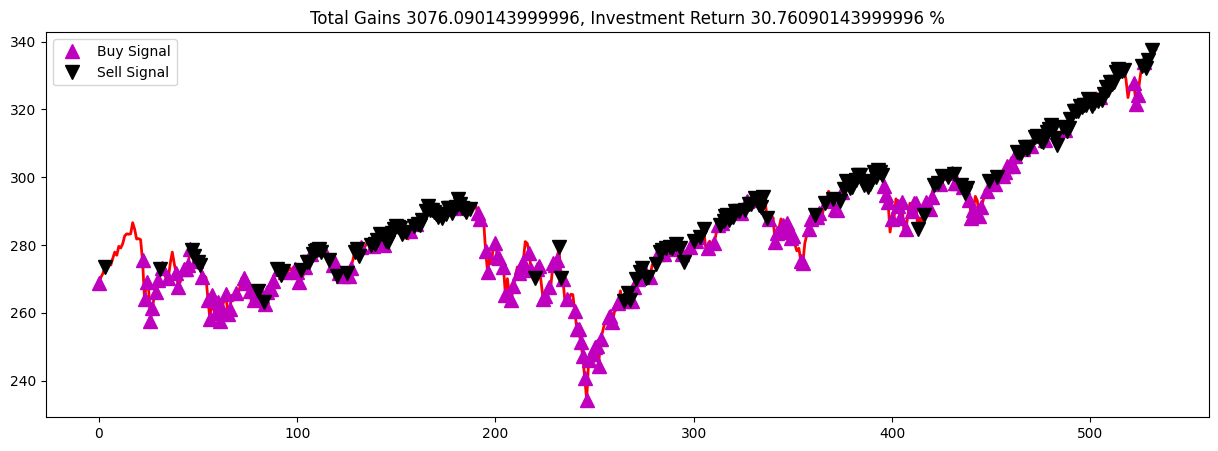

In [9]:
fig = plt.figure(figsize=(15, 5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label='Buy Signal', markevery=states_buy)
plt.plot(close, 'v', markersize=10, color='k', label='Sell Signal', markevery=states_sell)
plt.title(f'Total Gains {total_gains}, Investment Return {invest} %')
plt.legend()
plt.show()
